# Chapter 6: Collider Bias

**When Controlling Creates Spurious Associations**

## Goal

Understand **collider bias** - what happens when you control for a variable that is a **common effect** of two causes.

**Key insight:**
- Two independent causes affect the same outcome
- Controlling for the outcome creates a spurious association
- Makes independent variables appear correlated!

**The opposite of confounding**: 
- Confounding: Don't control → bias
- Collider: DO control → bias

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('default')
%matplotlib inline

np.random.seed(42)

print('✓ Imports loaded')

✓ Imports loaded


In [2]:
# Import quap
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap, QuapResult

print('✓ Loaded quap')

✓ Loaded quap


---

## Step 1: The Collider Structure

**Collider**: A variable with two (or more) arrows pointing INTO it

**DAG:**
```
X ──→ C ←── Y
```

Where:
- X and Y are **independent** (no causal relationship)
- Both X and Y cause C (C is the collider)
- X and Y are **unconditionally independent**

**The problem:**
- If you **condition on C** (control for it), X and Y become **dependent**
- Creates a **spurious association** between X and Y
- This is called **collider bias** or **selection bias**

---

## Step 2: Classic Example - Restaurant Selection

**Scenario**: You choose restaurants based on food quality OR ambiance (or both)

**DAG:**
```
Food Quality ──→ Selection ←── Ambiance
```

- Food and ambiance are independent
- You select restaurants with high food OR high ambiance
- Among selected restaurants, food and ambiance appear NEGATIVELY correlated!

**Intuition**: If a restaurant has bad food but you still chose it, it must have great ambiance!

In [3]:
# Simulate restaurant data
n = 200
np.random.seed(123)

# Food quality and ambiance are INDEPENDENT
food = np.random.normal(0, 1, n)
ambiance = np.random.normal(0, 1, n)

# Selection: choose if food OR ambiance is high
# (food + ambiance) > threshold
selection_score = food + ambiance
threshold = np.percentile(selection_score, 50)  # Top 50%
selected = selection_score > threshold

print(f"Total restaurants: {n}")
print(f"Selected: {np.sum(selected)} ({np.mean(selected):.0%})")
print(f"\nCorrelation (all restaurants):")
print(f"  food ~ ambiance: r = {np.corrcoef(food, ambiance)[0,1]:.3f}")
print("  ✓ Independent, as simulated")
print(f"\nCorrelation (selected only):")
print(f"  food ~ ambiance: r = {np.corrcoef(food[selected], ambiance[selected])[0,1]:.3f}")
print("  ⚠️ NEGATIVE! Conditioning on collider creates spurious correlation!")

Total restaurants: 200
Selected: 100 (50%)

Correlation (all restaurants):
  food ~ ambiance: r = 0.006
  ✓ Independent, as simulated

Correlation (selected only):
  food ~ ambiance: r = -0.396
  ⚠️ NEGATIVE! Conditioning on collider creates spurious correlation!


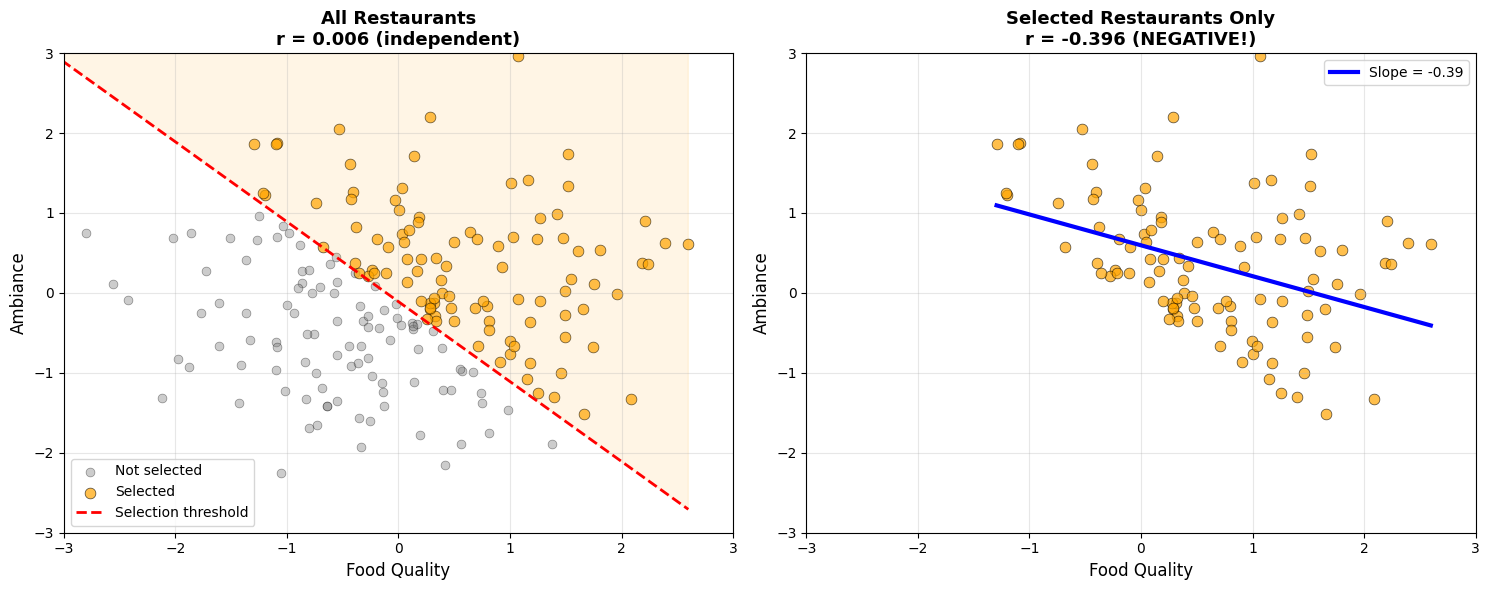


Key insight:
  • Left: All restaurants → food and ambiance independent
  • Right: Selected only → NEGATIVE correlation appears!
  • Conditioning on collider (selection) creates spurious association


In [4]:
# Visualize the collider bias
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: All restaurants
ax = axes[0]
ax.scatter(food[~selected], ambiance[~selected], s=40, alpha=0.4, 
          color='gray', label='Not selected', edgecolor='black', linewidth=0.5)
ax.scatter(food[selected], ambiance[selected], s=60, alpha=0.7, 
          color='orange', label='Selected', edgecolor='black', linewidth=0.5)
# Add selection boundary
x_line = np.linspace(food.min(), food.max(), 100)
y_line = threshold - x_line
ax.plot(x_line, y_line, 'r--', linewidth=2, label='Selection threshold')
ax.fill_between(x_line, y_line, 5, alpha=0.1, color='orange')

ax.set_xlabel('Food Quality', fontsize=12)
ax.set_ylabel('Ambiance', fontsize=12)
ax.set_title(f'All Restaurants\nr = {np.corrcoef(food, ambiance)[0,1]:.3f} (independent)', 
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# Plot 2: Selected restaurants only
ax = axes[1]
ax.scatter(food[selected], ambiance[selected], s=60, alpha=0.7, 
          color='orange', edgecolor='black', linewidth=0.5)
# Add regression line
slope, intercept = np.polyfit(food[selected], ambiance[selected], 1)
x_fit = np.linspace(food[selected].min(), food[selected].max(), 100)
ax.plot(x_fit, slope * x_fit + intercept, 'b-', linewidth=3, 
       label=f'Slope = {slope:.2f}')

ax.set_xlabel('Food Quality', fontsize=12)
ax.set_ylabel('Ambiance', fontsize=12)
corr_selected = np.corrcoef(food[selected], ambiance[selected])[0,1]
ax.set_title(f'Selected Restaurants Only\nr = {corr_selected:.3f} (NEGATIVE!)', 
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

print("\nKey insight:")
print("  • Left: All restaurants → food and ambiance independent")
print("  • Right: Selected only → NEGATIVE correlation appears!")
print("  • Conditioning on collider (selection) creates spurious association")

---

## Step 3: Academic Example - Newsworthiness vs Trustworthiness

From the book: Studies appearing in news

**DAG:**
```
Newsworthiness ──→ Appears in News ←── Trustworthiness
```

- Newsworthiness and trustworthiness are independent
- Both increase chance of appearing in news
- Among studies in news, they appear negatively correlated

**Why?** If a study is untrustworthy but still made the news, it must be very newsworthy!

In [5]:
# Simulate scientific studies
n = 1000
np.random.seed(456)

# Newsworthiness and trustworthiness are INDEPENDENT
newsworthiness = np.random.normal(0, 1, n)
trustworthiness = np.random.normal(0, 1, n)

# Appears in news: high on either dimension
news_score = newsworthiness + trustworthiness
threshold = np.percentile(news_score, 90)  # Top 10% make news
in_news = news_score > threshold

print(f"Total studies: {n}")
print(f"In news: {np.sum(in_news)} ({np.mean(in_news):.1%})")
print(f"\nCorrelation (all studies):")
print(f"  newsworthy ~ trustworthy: r = {np.corrcoef(newsworthiness, trustworthiness)[0,1]:.3f}")
print(f"\nCorrelation (in news only):")
print(f"  newsworthy ~ trustworthy: r = {np.corrcoef(newsworthiness[in_news], trustworthiness[in_news])[0,1]:.3f}")
print("  ⚠️ NEGATIVE correlation among studies that made the news!")

Total studies: 1000
In news: 100 (10.0%)

Correlation (all studies):
  newsworthy ~ trustworthy: r = 0.013

Correlation (in news only):
  newsworthy ~ trustworthy: r = -0.786
  ⚠️ NEGATIVE correlation among studies that made the news!


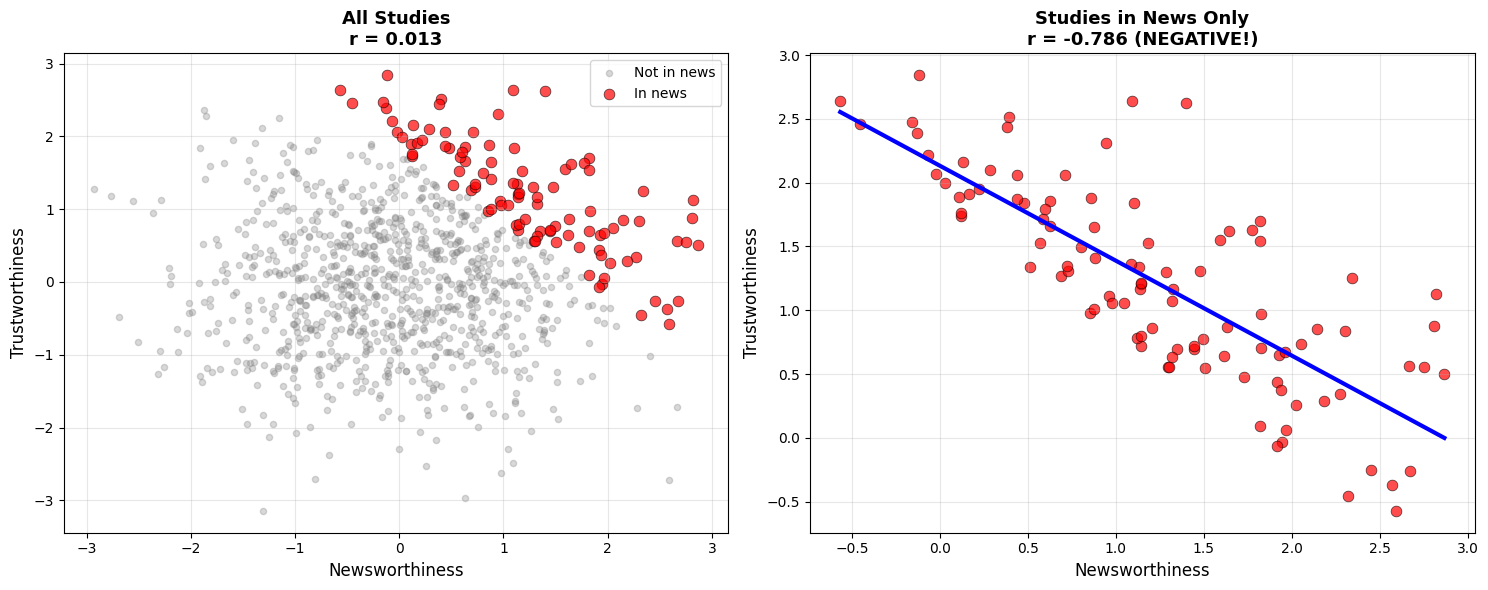


Implication:
  If you only analyze studies that made the news,
  you'll find a spurious NEGATIVE association between
  newsworthiness and trustworthiness!


In [6]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: All studies
ax = axes[0]
ax.scatter(newsworthiness[~in_news], trustworthiness[~in_news], s=20, alpha=0.3, 
          color='gray', label='Not in news')
ax.scatter(newsworthiness[in_news], trustworthiness[in_news], s=60, alpha=0.7, 
          color='red', label='In news', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Newsworthiness', fontsize=12)
ax.set_ylabel('Trustworthiness', fontsize=12)
ax.set_title(f'All Studies\nr = {np.corrcoef(newsworthiness, trustworthiness)[0,1]:.3f}', 
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Studies in news only
ax = axes[1]
ax.scatter(newsworthiness[in_news], trustworthiness[in_news], s=60, alpha=0.7, 
          color='red', edgecolor='black', linewidth=0.5)
slope2, intercept2 = np.polyfit(newsworthiness[in_news], trustworthiness[in_news], 1)
x_fit2 = np.linspace(newsworthiness[in_news].min(), newsworthiness[in_news].max(), 100)
ax.plot(x_fit2, slope2 * x_fit2 + intercept2, 'b-', linewidth=3)
ax.set_xlabel('Newsworthiness', fontsize=12)
ax.set_ylabel('Trustworthiness', fontsize=12)
corr_news = np.corrcoef(newsworthiness[in_news], trustworthiness[in_news])[0,1]
ax.set_title(f'Studies in News Only\nr = {corr_news:.3f} (NEGATIVE!)', 
            fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nImplication:")
print("  If you only analyze studies that made the news,")
print("  you'll find a spurious NEGATIVE association between")
print("  newsworthiness and trustworthiness!")

---

## Step 4: Regression Models Showing the Bias

Let's use the restaurant example and fit regression models.

In [7]:
# Prepare data
food_std = (food - food.mean()) / food.std()
ambiance_std = (ambiance - ambiance.mean()) / ambiance.std()

print("Variables standardized")

Variables standardized


In [8]:
# Model 1: Ambiance ~ Food (all restaurants)
def neg_log_posterior_all(params):
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * food_std
    log_lik = np.sum(stats.norm.logpdf(ambiance_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_all = quap(neg_log_posterior_all, [0, 0, np.log(1)], 
             ['alpha', 'beta_food', 'log_sigma'])
m_all.transform_param('log_sigma', 'sigma', np.exp)

print("Model 1: Ambiance ~ Food (ALL restaurants)")
print("="*70)
m_all.summary()

✓ Registered transformation: log_sigma -> sigma
Model 1: Ambiance ~ Food (ALL restaurants)
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0067 seconds
Log posterior at MAP: -284.32

            mean    std  89%_lower  89%_upper
alpha     0.0002 0.0666    -0.1042     0.1062
beta_food 0.0067 0.0703    -0.1065     0.1182
sigma     1.0013 0.0497     0.9245     1.0830


,mean,std,89%_lower,89%_upper
alpha,0.000178,0.066622,-0.104205,0.106198
beta_food,0.006750,0.070277,-0.106530,0.118182
sigma,1.001307,0.049674,0.924455,1.082989


In [9]:
# Model 2: Ambiance ~ Food (selected restaurants only)
def neg_log_posterior_selected(params):
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * food_std[selected]
    log_lik = np.sum(stats.norm.logpdf(ambiance_std[selected], loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_selected = quap(neg_log_posterior_selected, [0, 0, np.log(1)], 
                  ['alpha', 'beta_food', 'log_sigma'])
m_selected.transform_param('log_sigma', 'sigma', np.exp)

print("Model 2: Ambiance ~ Food (SELECTED restaurants only)")
print("="*70)
m_selected.summary()

✓ Registered transformation: log_sigma -> sigma
Model 2: Ambiance ~ Food (SELECTED restaurants only)
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0103 seconds
Log posterior at MAP: -130.02

             mean    std  89%_lower  89%_upper
alpha      0.5964 0.0932     0.4480     0.7438
beta_food -0.3313 0.0988    -0.4904    -0.1722
sigma      0.8455 0.0613     0.7510     0.9466


,mean,std,89%_lower,89%_upper
alpha,0.596413,0.093238,0.447983,0.743769
beta_food,-0.331287,0.098819,-0.490392,-0.172212
sigma,0.845539,0.061251,0.750965,0.946603


In [10]:
# Compare coefficients
coef_all = m_all.coef()
coef_selected = m_selected.coef()

comparison = pd.DataFrame({
    'All Restaurants': [coef_all['beta_food']],
    'Selected Only': [coef_selected['beta_food']]
}, index=['β_food'])

print("\nRegression Coefficient Comparison:")
print("="*70)
print(comparison)
print("="*70)

print("\n⚠️ COLLIDER BIAS!")
print(f"\n  ALL restaurants: β_food = {coef_all['beta_food']:.3f}")
print("    → Near zero (independent, as it should be)")
print(f"\n  SELECTED only: β_food = {coef_selected['beta_food']:.3f}")
print("    → NEGATIVE! (spurious association)")
print("\n💡 Conditioning on selection (collider) creates false correlation!")


Regression Coefficient Comparison:
        All Restaurants  Selected Only
β_food          0.00675      -0.331287

⚠️ COLLIDER BIAS!

  ALL restaurants: β_food = 0.007
    → Near zero (independent, as it should be)

  SELECTED only: β_food = -0.331
    → NEGATIVE! (spurious association)

💡 Conditioning on selection (collider) creates false correlation!


---

## Step 5: More Examples

### Example: Hollywood Success

**DAG:**
```
Talent ──→ Success ←── Beauty
```

- Talent and beauty are independent
- Both increase success probability
- Among successful actors, talent and beauty appear NEGATIVELY correlated
- "Beautiful actors must lack talent" (FALSE!)

### Example: Graduate Admissions

**DAG:**
```
Test Scores ──→ Admission ←── Research Experience
```

- Among admitted students, scores and experience appear negatively correlated
- Low scores? Must have great research!

### Example: Survival Bias (WWII Planes)

**DAG:**
```
Armor on Wings ──→ Survival ←── Armor on Engine
```

- Among surviving planes, wing damage and engine damage appear negatively correlated
- Wrong conclusion: Reinforce wings (they have more damage)
- Right answer: Reinforce engines (planes hit there didn't survive!)

---

## Step 6: Descendants of Colliders

**Important**: Conditioning on a **descendant** (consequence) of a collider also creates bias!

**DAG:**
```
X ──→ C ←── Y
      ↓
      D (descendant)
```

Conditioning on D also creates association between X and Y (though weaker than conditioning on C directly).

In [11]:
# Simulate descendant example
n = 500
np.random.seed(789)

# X and Y independent
x = np.random.normal(0, 1, n)
y = np.random.normal(0, 1, n)

# C is collider
c = x + y + np.random.normal(0, 0.5, n)

# D is descendant of C
d = c + np.random.normal(0, 0.5, n)

print("Correlations:")
print(f"\nUnconditional:")
print(f"  x ~ y: r = {np.corrcoef(x, y)[0,1]:.3f} (independent)")

print(f"\nConditioning on C (collider):")
# Stratify by C
c_high = c > np.median(c)
print(f"  x ~ y | C high: r = {np.corrcoef(x[c_high], y[c_high])[0,1]:.3f}")
print(f"  x ~ y | C low:  r = {np.corrcoef(x[~c_high], y[~c_high])[0,1]:.3f}")

print(f"\nConditioning on D (descendant of collider):")
d_high = d > np.median(d)
print(f"  x ~ y | D high: r = {np.corrcoef(x[d_high], y[d_high])[0,1]:.3f}")
print(f"  x ~ y | D low:  r = {np.corrcoef(x[~d_high], y[~d_high])[0,1]:.3f}")

print("\n✓ Conditioning on descendant also creates spurious correlation!")
print("  (Though weaker than conditioning on collider directly)")

Correlations:

Unconditional:
  x ~ y: r = -0.023 (independent)

Conditioning on C (collider):
  x ~ y | C high: r = -0.413
  x ~ y | C low:  r = -0.387

Conditioning on D (descendant of collider):
  x ~ y | D high: r = -0.377
  x ~ y | D low:  r = -0.348

✓ Conditioning on descendant also creates spurious correlation!
  (Though weaker than conditioning on collider directly)


---

## Step 7: How to Detect and Avoid Collider Bias

### Detection

1. **Draw the DAG**: Identify variables with arrows pointing INTO them
2. **Check causality**: Is the variable caused by multiple things?
3. **Look for selection**: Are you analyzing a selected subsample?

### Common Sources

- **Selection/Survival**: Only studying survivors, successes, or selected cases
- **Volunteer bias**: Only studying volunteers (who are selected)
- **Attrition**: Only studying completers (dropouts are selected out)
- **Stratification**: Controlling for downstream consequences

### Solution

**Don't control for colliders!**

| Variable Type | Should Control? |
|--------------|----------------|
| Pre-treatment confounder | ✓ YES |
| Post-treatment (mediator) | ✗ NO |
| Collider | ✗ NO |
| Descendant of collider | ✗ NO |

### The Rule

**Only control for pre-treatment confounders** that open backdoor paths!

---

## Summary

### What We Learned

**1. Collider Definition**
```
X ──→ C ←── Y
```
- C has arrows pointing INTO it
- X and Y are independent
- Controlling for C creates spurious association

**2. Why It Happens**
- Conditioning on a common effect
- Creates information flow between causes
- "If X is low but C is high, Y must be high"

**3. Real-World Examples**
- Restaurant selection (food & ambiance)
- News studies (trustworthy & newsworthy)
- Hollywood (talent & beauty)
- Survival bias (damage locations)
- Graduate admissions (scores & experience)

**4. Opposite of Confounding**

| Confounding | Collider |
|-------------|----------|
| X ← C → Y | X → C ← Y |
| DON'T control → bias | DO control → bias |
| Backdoor path | No backdoor path |
| Control to fix | Don't control to avoid |

**5. Detection Strategy**
- Draw the DAG
- Find variables with multiple arrows pointing IN
- Check if you're analyzing a selected subset
- Don't control for colliders!

**6. The Golden Rule**

**Use DAGs, not statistical associations, to decide what to control for!**

- Some variables should be controlled (confounders)
- Some variables should NOT be controlled (post-treatment, colliders)
- You can't tell from data alone - need causal theory

---

**Key takeaway**: More variables in regression ≠ better! Sometimes controlling makes things worse.